In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
generated_folder="/content/drive/MyDrive/Images/Generated"
original_folder="/content/drive/MyDrive/Images/Original"
output_base = '/content/drive/MyDrive/projectImages/dataset_split'
train_generated = os.path.join(output_base, 'train/generated')
train_original = os.path.join(output_base, 'train/original')
test_generated = os.path.join(output_base, 'test/generated')
test_original = os.path.join(output_base, 'test/original')

# Create output directories
for path in [train_generated, train_original, test_generated, test_original]:
    os.makedirs(path, exist_ok=True)

In [ ]:
# List all files
import shutil
from sklearn.model_selection import train_test_split
generated_files = [f for f in os.listdir(generated_folder) if os.path.isfile(os.path.join(generated_folder, f))]
original_files = [f for f in os.listdir(original_folder) if os.path.isfile(os.path.join(original_folder, f))]

train_files, test_files = train_test_split(generated_files, test_size=0.1, random_state=42)
trainoriginal_files, testoriginal_files = train_test_split(original_files, test_size=0.1, random_state=42)
def copy_files(file_list, src_folder, dest_folder):
    for file in file_list:
        src_path = os.path.join(src_folder, file)
        dest_path = os.path.join(dest_folder, file)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"Warning: {file} not found in {src_folder}")


# Corrected copy calls
copy_files(train_files, generated_folder, train_generated)
copy_files(test_files, generated_folder, test_generated)

copy_files(trainoriginal_files, original_folder, train_original)  # fixed
copy_files(testoriginal_files, original_folder, test_original)    # fixed

print(f"Done! {len(train_files)} for training, {len(test_files)} for testing.")

Done! 2044 for training, 228 for testing.


In [ ]:
import os

os.makedirs('/content/drive/MyDrive/projectImages', exist_ok=True)

In [ ]:
!unzip -q "/content/drive/MyDrive/dataset_split-20250613T200929Z-1-001.zip" -d "/content/drive/MyDrive/projectImages"

In [ ]:
import os

# Define the folders
train_original_folder = "/content/drive/MyDrive/projectImages/dataset_split/train/original"
train_generated_folder = "/content/drive/MyDrive/projectImages/dataset_split/train/generated"
test_original_folder = "/content/drive/MyDrive/projectImages/dataset_split/test/original"
test_generated_folder = "/content/drive/MyDrive/projectImages/dataset_split/test/generated"

# Define valid image extensions
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

# Count images in a folder
def count_images(folder):
    return sum(1 for file in os.listdir(folder) if file.lower().endswith(image_extensions))

# Get the counts
train_original_count = count_images(train_original_folder)
train_generated_count = count_images(train_generated_folder)
test_original_count = count_images(test_original_folder)
test_generated_count = count_images(test_generated_folder)

# Print the counts
print(f"Train - Original: {train_original_count} | Generated: {train_generated_count}")
print(f"Test  - Original: {test_original_count} | Generated: {test_generated_count}")


Train - Original: 7437 | Generated: 7460
Test  - Original: 827 | Generated: 829


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks

train_dir = os.path.join(output_base, 'train')
test_dir  = os.path.join(output_base, 'test')
IMG_SIZE = (224, 224)       # MobileNetV2 default input size is 224x224
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1,      # reserve 10% of train for validation
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=SEED
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


Found 13408 images belonging to 2 classes.
Found 1489 images belonging to 2 classes.
Found 1656 images belonging to 2 classes.
Class indices: {'generated': 0, 'original': 1}


In [ ]:
#build mobilenetv2 model
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
# Add classification head
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)  # ensure batchnorm runs in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc'),
             F1Score(name='f1_score')],

    run_eagerly=True

)

In [ ]:
# 4. Callbacks
checkpoint_path = '/content/drive/MyDrive/projectImages/mobilenet_finetune/checkpoint.h5'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)
earlystop_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb, earlystop_cb]
)




/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6976 - auc: 0.7645 - f1_score: 0.6951 - loss: 0.5620 - precision: 0.6963 - recall: 0.6945
Epoch 1: val_auc improved from -inf to 0.95851, saving model to /content/drive/MyDrive/projectImages/mobilenet_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 494s 1s/step - accuracy: 0.6978 - auc: 0.7648 - f1_score: 0.6953 - loss: 0.5617 - precision: 0.6965 - recall: 0.6948 - val_accuracy: 0.8529 - val_auc: 0.9585 - val_f1_score: 0.8352 - val_loss: 0.3461 - val_precision: 0.9471 - val_recall: 0.7470
Epoch 2/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.8931 - auc: 0.9618 - f1_score: 0.8908 - loss: 0.2626 - precision: 0.8961 - recall: 0.8858
Epoch 2: val_auc improved from 0.95851 to 0.97666, saving model to /content/drive/MyDrive/projectImages/mobilenet_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.8932 - auc: 0.9618 - f1_score: 0.8909 - loss: 0.2625 - precision: 0.8961 - recall: 0.8859 - val_accuracy: 0.9181 - val_auc: 0.9767 - val_f1_score: 0.9195 - val_loss: 0.2284 - val_precision: 0.9017 - val_recall: 0.9381
Epoch 3/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.9164 - auc: 0.9747 - f1_score: 0.9180 - loss: 0.2105 - precision: 0.9149 - recall: 0.9212
Epoch 3: val_auc improved from 0.97666 to 0.98230, saving model to /content/drive/MyDrive/projectImages/mobilenet_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 425s 982ms/step - accuracy: 0.9164 - auc: 0.9747 - f1_score: 0.9180 - loss: 0.2105 - precision: 0.9149 - recall: 0.9213 - val_accuracy: 0.9255 - val_auc: 0.9823 - val_f1_score: 0.9232 - val_loss: 0.2045 - val_precision: 0.9501 - val_recall: 0.8977
Epoch 4/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.9286 - auc: 0.9812 - f1_score: 0.9281 - loss: 0.1808 - precision: 0.9275 - recall: 0.9288
Epoch 4: val_auc improved from 0.98230 to 0.98698, saving model to /content/drive/MyDrive/projectImages/mobilenet_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 446s 992ms/step - accuracy: 0.9286 - auc: 0.9812 - f1_score: 0.9281 - loss: 0.1808 - precision: 0.9275 - recall: 0.9288 - val_accuracy: 0.9174 - val_auc: 0.9870 - val_f1_score: 0.9114 - val_loss: 0.2037 - val_precision: 0.9799 - val_recall: 0.8520
Epoch 5/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.9365 - auc: 0.9844 - f1_score: 0.9361 - loss: 0.1639 - precision: 0.9390 - recall: 0.9334
Epoch 5: val_auc did not improve from 0.98698
419/419 ━━━━━━━━━━━━━━━━━━━━ 439s 985ms/step - accuracy: 0.9365 - auc: 0.9844 - f1_score: 0.9361 - loss: 0.1639 - precision: 0.9390 - recall: 0.9334 - val_accuracy: 0.9315 - val_auc: 0.9856 - val_f1_score: 0.9282 - val_loss: 0.1841 - val_precision: 0.9734 - val_recall: 0.8869
Epoch 6/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9381 - auc: 0.9863 - f1_score: 0.9390 - loss: 0.1540 - precision: 0.9385 - recall: 0.9394
Epoch 6: val_auc improved from 0.98698 to 0.99013, saving model to /content/drive/My

419/419 ━━━━━━━━━━━━━━━━━━━━ 424s 944ms/step - accuracy: 0.9381 - auc: 0.9863 - f1_score: 0.9390 - loss: 0.1540 - precision: 0.9385 - recall: 0.9394 - val_accuracy: 0.9335 - val_auc: 0.9901 - val_f1_score: 0.9305 - val_loss: 0.1635 - val_precision: 0.9721 - val_recall: 0.8923
Epoch 7/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.9444 - auc: 0.9877 - f1_score: 0.9441 - loss: 0.1439 - precision: 0.9456 - recall: 0.9427
Epoch 7: val_auc did not improve from 0.99013
419/419 ━━━━━━━━━━━━━━━━━━━━ 390s 930ms/step - accuracy: 0.9444 - auc: 0.9877 - f1_score: 0.9441 - loss: 0.1439 - precision: 0.9456 - recall: 0.9427 - val_accuracy: 0.9167 - val_auc: 0.9865 - val_f1_score: 0.9110 - val_loss: 0.1983 - val_precision: 0.9754 - val_recall: 0.8546
Epoch 8/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.9503 - auc: 0.9899 - f1_score: 0.9494 - loss: 0.1305 - precision: 0.9490 - recall: 0.9499
Epoch 8: val_auc did not improve from 0.99013
419/419 ━━━━━━━━━━━━━━━━━━━━ 441s 926m

419/419 ━━━━━━━━━━━━━━━━━━━━ 460s 993ms/step - accuracy: 0.9568 - auc: 0.9926 - f1_score: 0.9566 - loss: 0.1138 - precision: 0.9549 - recall: 0.9583 - val_accuracy: 0.9443 - val_auc: 0.9923 - val_f1_score: 0.9422 - val_loss: 0.1419 - val_precision: 0.9755 - val_recall: 0.9112
Epoch 12/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.9592 - auc: 0.9937 - f1_score: 0.9591 - loss: 0.1060 - precision: 0.9597 - recall: 0.9585
Epoch 12: val_auc improved from 0.99231 to 0.99270, saving model to /content/drive/MyDrive/projectImages/mobilenet_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 431s 966ms/step - accuracy: 0.9592 - auc: 0.9937 - f1_score: 0.9591 - loss: 0.1060 - precision: 0.9597 - recall: 0.9585 - val_accuracy: 0.9369 - val_auc: 0.9927 - val_f1_score: 0.9339 - val_loss: 0.1445 - val_precision: 0.9779 - val_recall: 0.8937
Epoch 13/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.9578 - auc: 0.9930 - f1_score: 0.9582 - loss: 0.1081 - precision: 0.9580 - recall: 0.9584
Epoch 13: val_auc improved from 0.99270 to 0.99458, saving model to /content/drive/MyDrive/projectImages/mobilenet_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 430s 937ms/step - accuracy: 0.9578 - auc: 0.9930 - f1_score: 0.9582 - loss: 0.1081 - precision: 0.9580 - recall: 0.9584 - val_accuracy: 0.9469 - val_auc: 0.9946 - val_f1_score: 0.9442 - val_loss: 0.1415 - val_precision: 0.9940 - val_recall: 0.8991
Epoch 14/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.9623 - auc: 0.9941 - f1_score: 0.9624 - loss: 0.1020 - precision: 0.9650 - recall: 0.9599
Epoch 14: val_auc did not improve from 0.99458
419/419 ━━━━━━━━━━━━━━━━━━━━ 459s 980ms/step - accuracy: 0.9623 - auc: 0.9941 - f1_score: 0.9624 - loss: 0.1020 - precision: 0.9650 - recall: 0.9599 - val_accuracy: 0.9382 - val_auc: 0.9923 - val_f1_score: 0.9356 - val_loss: 0.1462 - val_precision: 0.9752 - val_recall: 0.8991
Epoch 15/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.9646 - auc: 0.9947 - f1_score: 0.9649 - loss: 0.0964 - precision: 0.9627 - recall: 0.9670
Epoch 15: val_auc did not improve from 0.99458
419/419 ━━━━━━━━━━━━━━━━━━━━ 408s 

419/419 ━━━━━━━━━━━━━━━━━━━━ 411s 981ms/step - accuracy: 0.9623 - auc: 0.9943 - f1_score: 0.9623 - loss: 0.0993 - precision: 0.9637 - recall: 0.9609 - val_accuracy: 0.9510 - val_auc: 0.9947 - val_f1_score: 0.9493 - val_loss: 0.1217 - val_precision: 0.9799 - val_recall: 0.9206
Epoch 17/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.9663 - auc: 0.9950 - f1_score: 0.9663 - loss: 0.0925 - precision: 0.9660 - recall: 0.9666
Epoch 17: val_auc did not improve from 0.99472
419/419 ━━━━━━━━━━━━━━━━━━━━ 400s 955ms/step - accuracy: 0.9663 - auc: 0.9950 - f1_score: 0.9663 - loss: 0.0925 - precision: 0.9660 - recall: 0.9666 - val_accuracy: 0.9375 - val_auc: 0.9934 - val_f1_score: 0.9346 - val_loss: 0.1407 - val_precision: 0.9794 - val_recall: 0.8937
Epoch 18/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.9621 - auc: 0.9944 - f1_score: 0.9616 - loss: 0.0967 - precision: 0.9649 - recall: 0.9583
Epoch 18: val_auc did not improve from 0.99472
419/419 ━━━━━━━━━━━━━━━━━━━━ 434s 

419/419 ━━━━━━━━━━━━━━━━━━━━ 451s 958ms/step - accuracy: 0.9690 - auc: 0.9953 - f1_score: 0.9690 - loss: 0.0875 - precision: 0.9701 - recall: 0.9679 - val_accuracy: 0.9563 - val_auc: 0.9950 - val_f1_score: 0.9548 - val_loss: 0.1171 - val_precision: 0.9871 - val_recall: 0.9246
Epoch 20/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.9717 - auc: 0.9961 - f1_score: 0.9714 - loss: 0.0814 - precision: 0.9713 - recall: 0.9715
Epoch 20: val_auc did not improve from 0.99497
419/419 ━━━━━━━━━━━━━━━━━━━━ 443s 960ms/step - accuracy: 0.9717 - auc: 0.9961 - f1_score: 0.9714 - loss: 0.0814 - precision: 0.9713 - recall: 0.9715 - val_accuracy: 0.9436 - val_auc: 0.9948 - val_f1_score: 0.9405 - val_loss: 0.1376 - val_precision: 0.9925 - val_recall: 0.8937
Restoring model weights from the end of the best epoch: 19.


In [ ]:
results = model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

# See in what order they come back:
print(model.metrics_names)
# e.g. ['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1_score']

loss, accuracy, precision, recall, auc, f1_score = results

print(f"Test → loss: {loss:.4f}")
print(f"       accuracy: {accuracy:.3f}")
print(f"       precision: {precision:.3f}")
print(f"       recall: {recall:.3f}")
print(f"       AUC: {auc:.3f}")
print(f"       F1‑score: {f1_score:.3f}")


52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - accuracy: 0.9961 - auc: 0.5282 - f1_score: 0.5188 - loss: 0.0241 - precision: 0.5213 - recall: 0.5172
['loss', 'compile_metrics']
Test → loss: 0.0216
       accuracy: 0.996
       precision: 0.999
       recall: 0.994
       AUC: 1.000
       F1‑score: 0.996


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1) Predict probabilities or logits
y_prob = model.predict(test_generator, steps=len(test_generator))
# 2) Convert to binary labels (threshold=0.5 by default)
y_pred = (y_prob > 0.5).astype(int).flatten()

# 3) True labels
y_true = test_generator.classes  # assuming ImageDataGenerator.flow_from_directory

# 4) Classification report & confusion matrix
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 287ms/step
              precision    recall  f1-score   support

   generated       0.99      1.00      1.00       829
    original       1.00      0.99      1.00       827

    accuracy                           1.00      1656
   macro avg       1.00      1.00      1.00      1656
weighted avg       1.00      1.00      1.00      1656

Confusion Matrix:
 [[828   1]
 [  5 822]]


52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 300ms/step


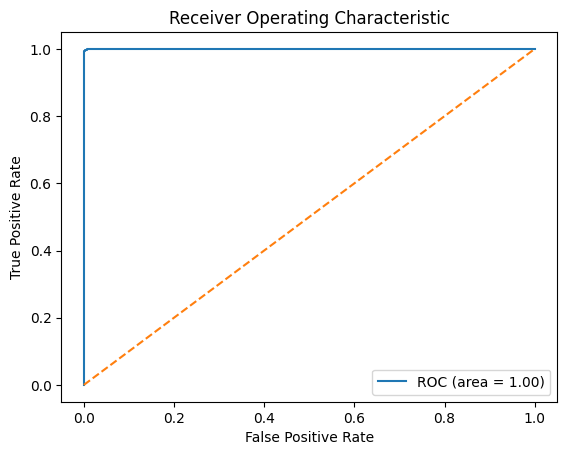

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict(test_generator, steps=len(test_generator)).ravel()
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
